In [ ]:
#http://www.degeneratestate.org/posts/2018/Jan/04/reducing-the-variance-of-ab-test-using-prior-information/

In [4]:
import numpy as np
import seaborn as sns

AttributeError: type object 'pandas._libs.tslibs.conversion._TSObject' has no attribute '__reduce_cython__'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline

KeyboardInterrupt: 

In [7]:
def generate_dataset(n_samples=100, uplift=0):
    x = np.random.uniform(low=0, high=1, size=n_samples*2)
    y = (
        + 10 * np.abs(x - 0.25)  
        + 2 * np.sin((x * 5) * 2 * np.pi)
        + np.random.normal(size=n_samples*2)
    )
    
    assignment = [1] * n_samples + [0] * n_samples
    np.random.shuffle(assignment)
    
    samples = pd.DataFrame({
        "x": x,
        "y": y,
        "group": assignment
    })
    
    samples.loc[lambda df: df.group == 1, "y"] += uplift
    
    return samples

In [8]:
ds = generate_dataset(n_samples=1000, uplift=1)
ds.head()

,x,y,group
0,0.569308,1.922512,0
1,0.520252,1.940856,1
2,0.425933,4.750401,1
3,0.072776,5.205005,0
4,0.133643,0.655472,1


/Users/didi/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


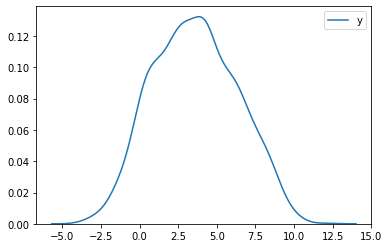

In [11]:
sns.kdeplot(ds.y)

In [12]:
from scipy.stats import norm

sample_size = 1000
alpha = 0.05
z = norm.isf(alpha / 2)
estimated_variance = ds.y.var()

detectable_effect_size = z * np.sqrt(2 * estimated_variance / sample_size)
detectable_effect_size

0.23819490861753484

Points with significant effect: 12/20
Points whose confidence interval covers the true effect size: 1/20


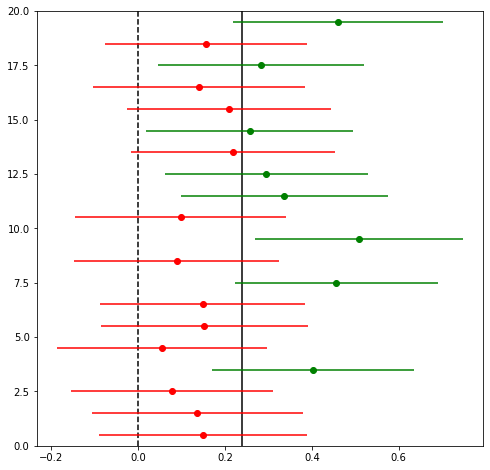

In [15]:
from scipy.stats import ttest_ind

n_experiments = 20
uplift = 0.24
sample_size = 1000
alpha = 0.05
z = norm.isf(alpha / 2)

results = []
is_significant = []

# run some experiments
for _ in range(n_experiments):
    ds = generate_dataset(n_samples=sample_size,uplift=uplift)
    base = ds[ds.group == 0]
    variant = ds[ds.group == 1]
    
    # estimated effect size is just the difference in means
    estimated_effect_size = variant.y.mean() - base.y.mean()
    
    # estiamated error is the combined variance of each group
    estimated_effect_err = 2 * np.sqrt(
        variant.y.var()/variant.shape[0] + 
        base.y.var() / base.shape[0]
    )
    results.append((estimated_effect_size, estimated_effect_err))
    
    # t-test to check if significant
    t,p = ttest_ind(base.y.values, variant.y.values)
    is_significant.append(p <= 0.05)
    
    
# plot everything
y = np.arange(n_experiments) + 0.5
x = np.asarray([i[0] for i in results])
xerr = np.asarray([i[1] for i in results])
is_significant = np.array(is_significant)

plt.figure(figsize=(8,8))
plt.vlines(0, 0, len(results), linestyles="dashed")
plt.vlines(uplift, 0, len(results))
plt.ylim(0,len(results))

mask = is_significant
plt.errorbar(x[mask],y[mask],xerr=xerr[mask], ls="none", c="g", marker="o")
mask = ~mask
plt.errorbar(x[mask],y[mask],xerr=xerr[mask], ls="none", c="r", marker="o");

print("Points with significant effect: {}/{}".format(np.sum(mask), n_experiments))
print("Points whose confidence interval covers the true effect size: {}/{}".format(
    np.sum(np.abs(x-uplift) > xerr), n_experiments))

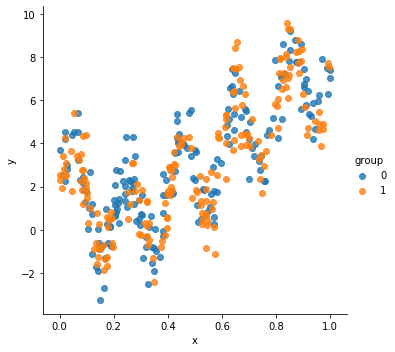

In [16]:
ds = generate_dataset(n_samples=200)
sns.lmplot(data=ds, x="x", y="y", hue="group", fit_reg=False)


In [17]:
correlation = ds.corr().loc["x","y"]
correlation

0.6850023587172256

In [18]:
def run_many_times(dataset_generator, estimator, n_runs):
    return np.array([estimator(dataset_generator()) for _ in range(n_runs)])

def compare_estimators(dataset_generator, estimators, true_uplift, n_runs=500):
    results = {}
    
    for estimator_name, estimator in estimators.items():
        res = run_many_times(dataset_generator, estimator, n_runs)
        sns.kdeplot(res, shade=True, label=estimator_name)
        
        print("Estimator: {}".format(estimator_name))
        print("\tConfidence Interval Width: {:.3f}".format(2 * np.std(res)))
        print("\tBias: {:.3f}".format(np.mean(res - true_uplift)))
        results[estimator_name] = res
        
    ymin, ymax = plt.ylim()
    plt.vlines(uplift, 0, ymax)
    plt.vlines(0, 0, ymax, linestyles="dashed")
    plt.ylim(0, ymax)
    
    return results

In [19]:
def base_estimator(ds):
    a = ds[ds.group == 0]
    b = ds[ds.group == 1]
    return b.y.mean() - a.y.mean()

/Users/didi/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Estimator: base
	Confidence Interval Width: 0.235
	Bias: 0.007


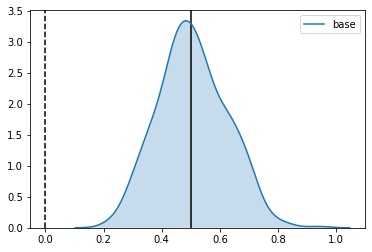

In [20]:
uplift = 0.5
n_samples = 1000
generator = lambda : generate_dataset(uplift=uplift, n_samples=n_samples)

results = compare_estimators(
    dataset_generator=generator,
    estimators={
        "base": base_estimator,
    },
    true_uplift=uplift
)

In [21]:
def cv_estimator(ds):
    theta = ds.cov().loc["x", "y"] / ds.cov().loc["x", "x"]
    
    ds_copy = ds.copy()
    ds_copy.y = ds.y - theta * ds.x
    
    return base_estimator(ds_copy)

/Users/didi/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Estimator: base
	Confidence Interval Width: 0.224
	Bias: 0.009
Estimator: control variate estimator
	Confidence Interval Width: 0.180
	Bias: -0.001


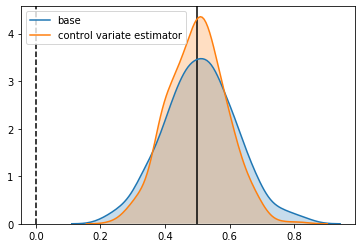

In [22]:
uplift = 0.5
n_samples = 1000
generator = lambda : generate_dataset(uplift=uplift, n_samples=n_samples)

results = compare_estimators(
    dataset_generator=generator,
    estimators={
        "base": base_estimator,
        "control variate estimator": cv_estimator
    },
    true_uplift=uplift
)

In [23]:
np.sqrt((1 - correlation ** 2) * estimated_variance) 

1.979808994068699

In [24]:
from sklearn.ensemble import RandomForestRegressor

def rf_estimator(ds):
    X = ds.x.values.reshape(-1,1)
    y = ds.y.values
    reg = RandomForestRegressor()
    reg.fit(X,y)
    
    ds_copy = ds.copy()
    ds_copy.y = ds.y - reg.predict(X)
    
    return base_estimator(ds_copy)

/Users/didi/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


/Users/didi/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Estimator: base
	Confidence Interval Width: 0.243
	Bias: 0.003
Estimator: control variate estimator
	Confidence Interval Width: 0.177
	Bias: 0.001


/Users/didi/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Estimator: random forest estimator
	Confidence Interval Width: 0.048
	Bias: -0.316


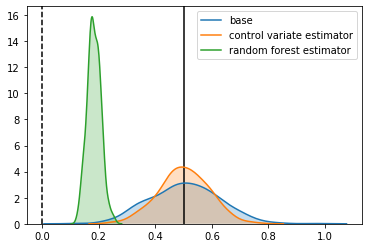

In [25]:
uplift = 0.5
n_samples = 1000
generator = lambda : generate_dataset(uplift=uplift, n_samples=n_samples)

results = compare_estimators(
    dataset_generator=generator,
    estimators={
        "base": base_estimator,
        "control variate estimator": cv_estimator,
        "random forest estimator": rf_estimator
    },
    true_uplift=uplift
)

/Users/didi/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Estimator: base
	Confidence Interval Width: 5.309
	Bias: -0.004
Estimator: control_variate
	Confidence Interval Width: 7.065
	Bias: -3.432


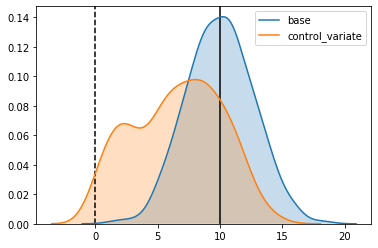

In [26]:
uplift = 10
n_samples = 2
generator = lambda : generate_dataset(uplift=uplift, n_samples=n_samples)

results = compare_estimators(
    dataset_generator=generator,
    estimators={
        "base": base_estimator,
        "control_variate": cv_estimator,
    },
    true_uplift=uplift
)


In [27]:
from sklearn.model_selection import KFold

def stacked_estimator(ds):
    kfold = KFold(n_splits=10)

    X = ds.x.values.reshape(-1,1)
    y = ds.y.values
    
    reg = RandomForestRegressor()
    
    ds_copy = ds.copy()
    ds_copy["y_pred"] = 0

    for train_index, test_index in kfold.split(X):
        
        X_train, X_test = X[train_index], X[test_index]      
        y_train, y_test = y[train_index], y[test_index]
        
        reg.fit(X_train,y_train)
        ds_copy.loc[test_index, "y_pred"] = reg.predict(X[test_index])
    
    ds_copy.y = ds_copy.y - ds_copy["y_pred"]
    
    return base_estimator(ds_copy)

/Users/didi/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Estimator: base
	Confidence Interval Width: 0.238
	Bias: 0.002
Estimator: control variate estimator
	Confidence Interval Width: 0.180
	Bias: -0.005


/Users/didi/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Estimator: stacked random forest estimator
	Confidence Interval Width: 0.117
	Bias: -0.001


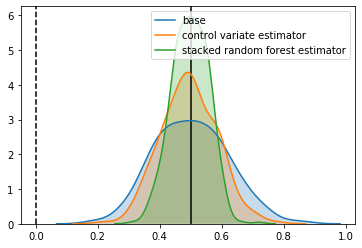

In [28]:
uplift = 0.5
n_samples = 1000
generator = lambda : generate_dataset(uplift=uplift, n_samples=n_samples)

results = compare_estimators(
    dataset_generator=generator,
    estimators={
        "base": base_estimator,
        "control variate estimator": cv_estimator,
        "stacked random forest estimator": stacked_estimator
    },
    true_uplift=uplift
)


In [29]:
from sklearn.model_selection import KFold

def stacked_cv_estimator(ds):
    kfold = KFold(n_splits=10)

    X = ds.x.values.reshape(-1,1)
    y = ds.y.values
    
    reg = RandomForestRegressor()
    
    ds_copy = ds.copy()
    ds_copy["y_pred"] = 0

    for train_index, test_index in kfold.split(X):
        
        X_train, X_test = X[train_index], X[test_index]      
        y_train, y_test = y[train_index], y[test_index]
        
        reg.fit(X_train,y_train)
        ds_copy.loc[test_index, "y_pred"] = reg.predict(X[test_index])
    
    ds_copy.x = ds_copy["y_pred"]
    
    return cv_estimator(ds_copy)

/Users/didi/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Estimator: base
	Confidence Interval Width: 0.234
	Bias: -0.007
Estimator: control variate estimator
	Confidence Interval Width: 0.173
	Bias: 0.008


/Users/didi/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Estimator: stacked random forest estimator
	Confidence Interval Width: 0.103
	Bias: -0.000


/Users/didi/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Estimator: stacked random forest CV estimator
	Confidence Interval Width: 0.105
	Bias: 0.001


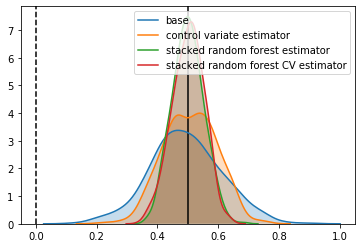

In [30]:
uplift = 0.5
n_samples = 1000
generator = lambda : generate_dataset(uplift=uplift, n_samples=n_samples)

results = compare_estimators(
    dataset_generator=generator,
    estimators={
        "base": base_estimator,
        "control variate estimator": cv_estimator,
        "stacked random forest estimator": stacked_estimator,
        "stacked random forest CV estimator": stacked_cv_estimator,
    },
    true_uplift=uplift
)


In [31]:
z * np.sqrt(2 / 1000)

0.08765225405765817